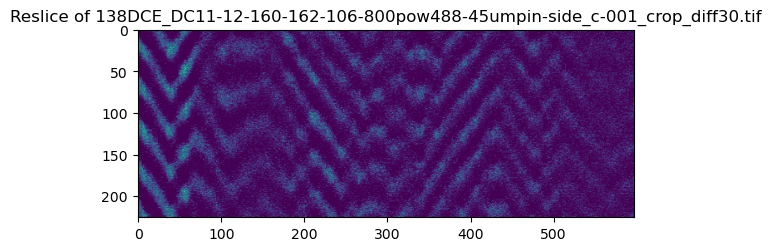

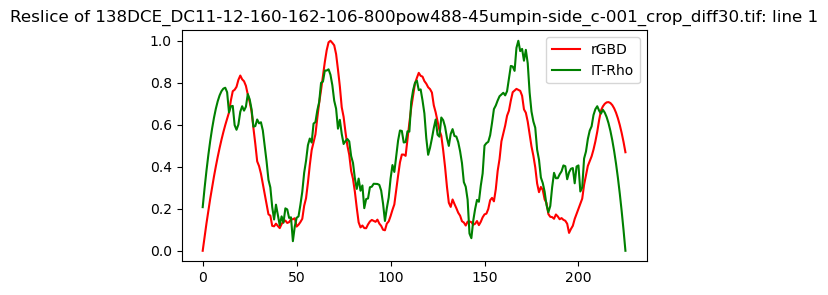

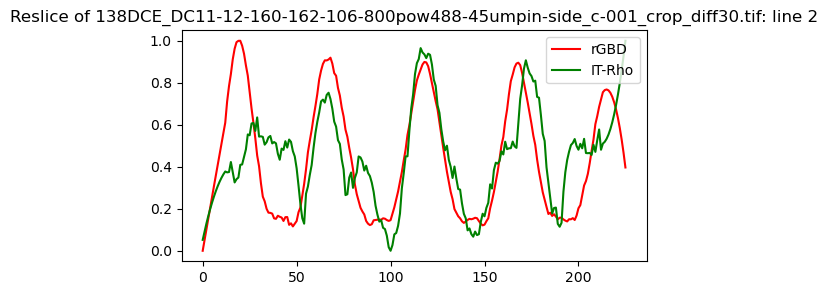

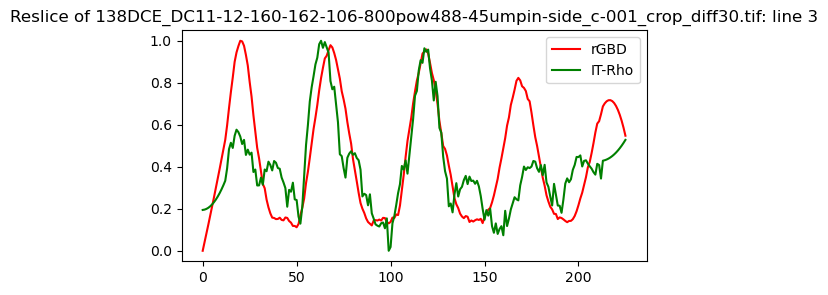

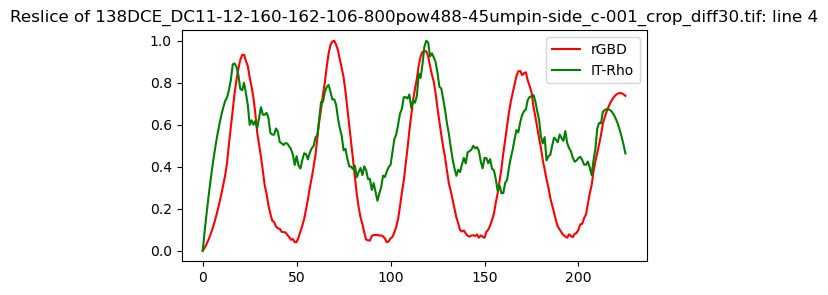

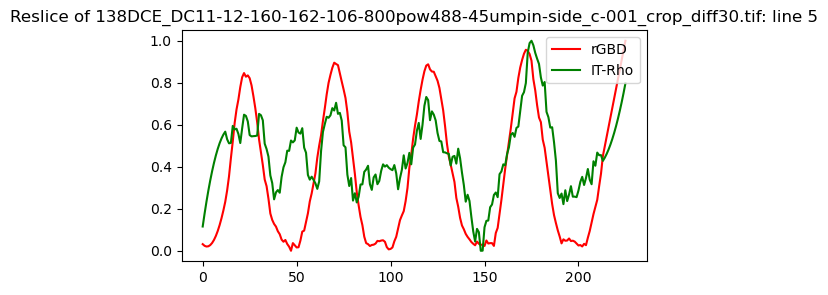

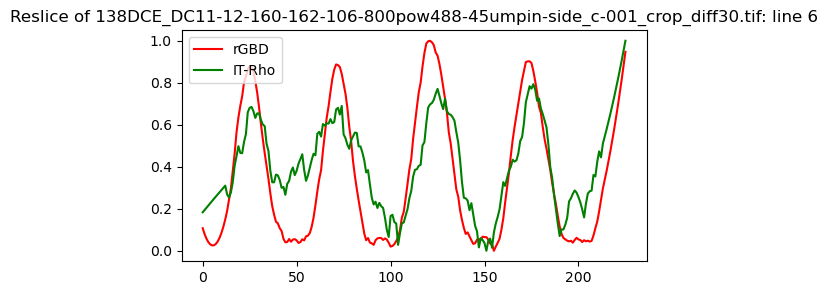

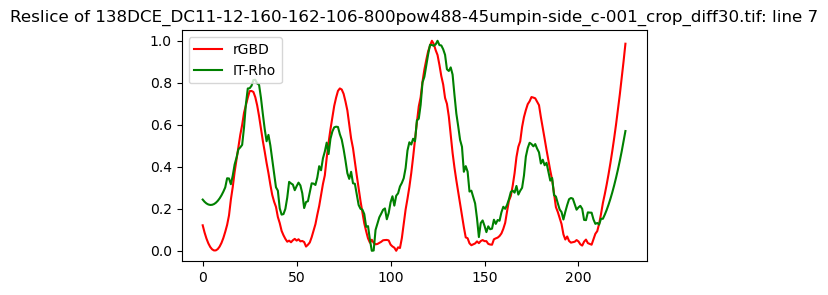

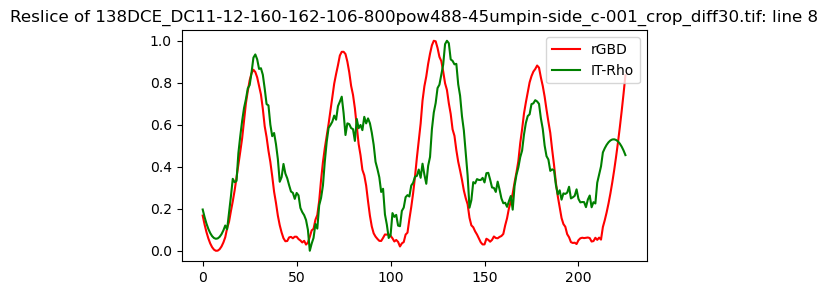

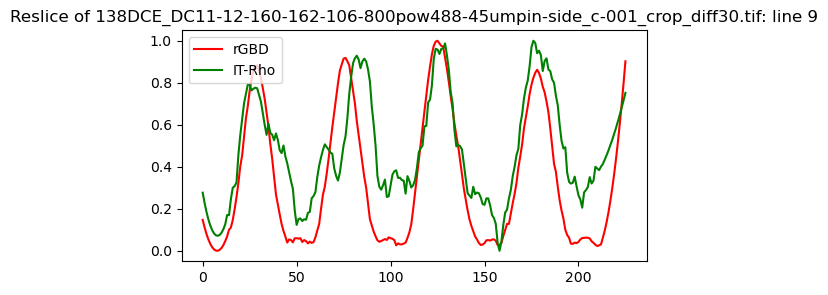

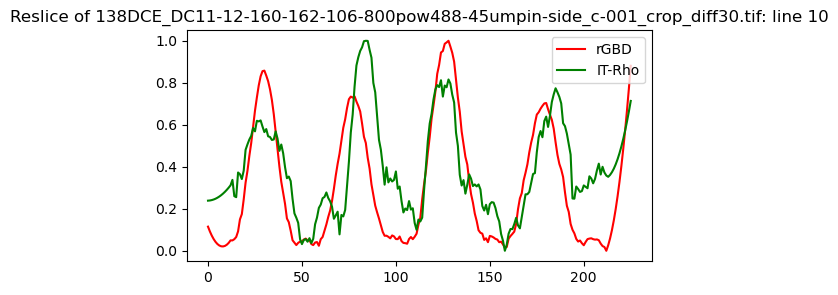

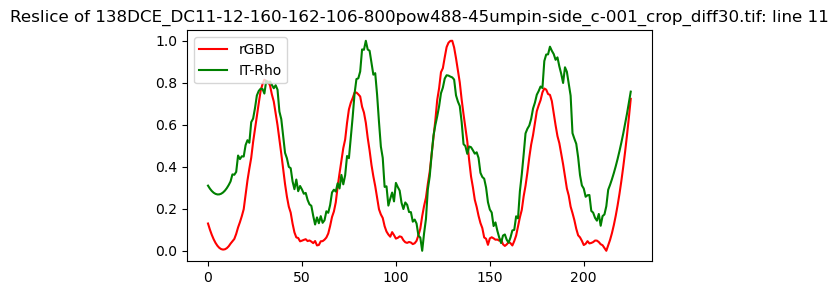

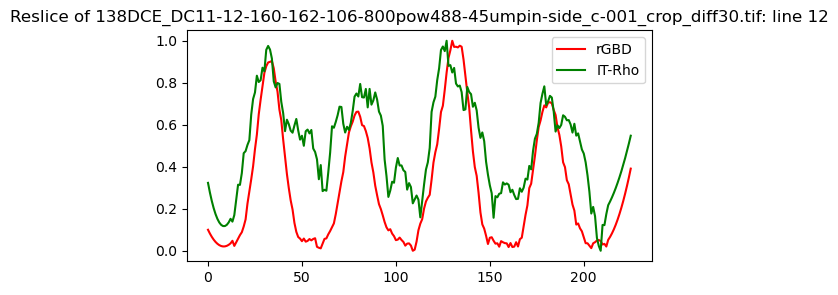

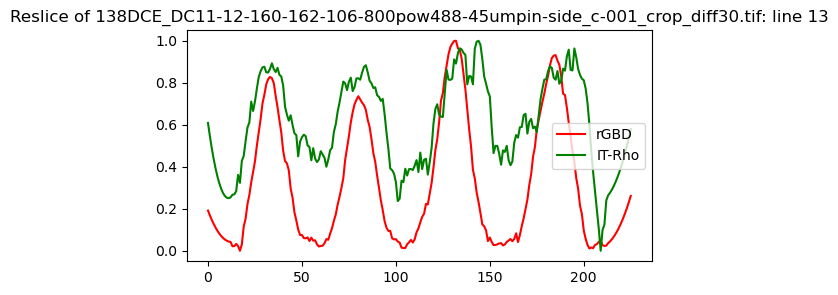

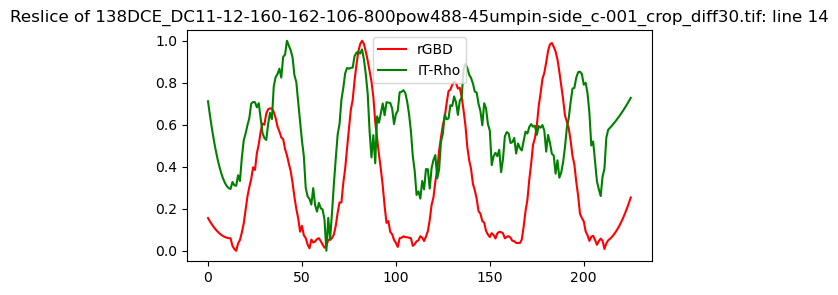

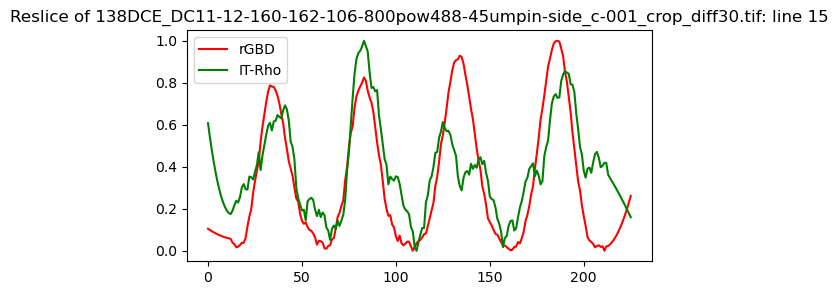

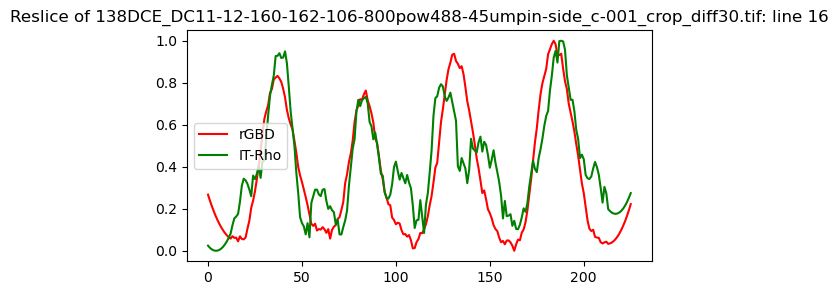

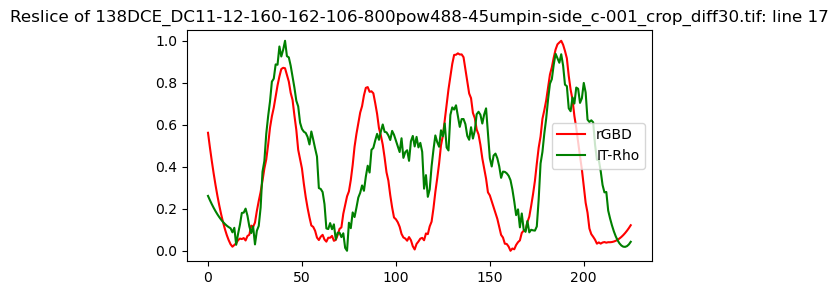

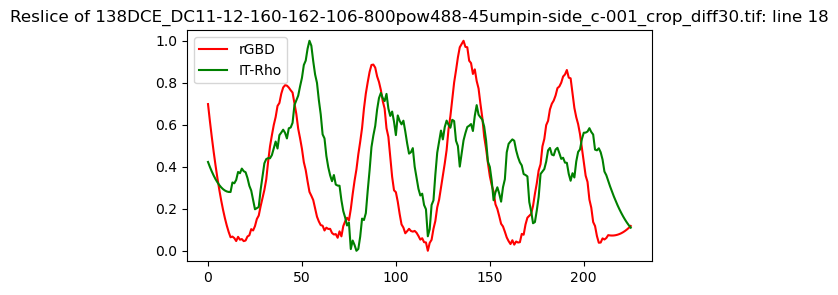

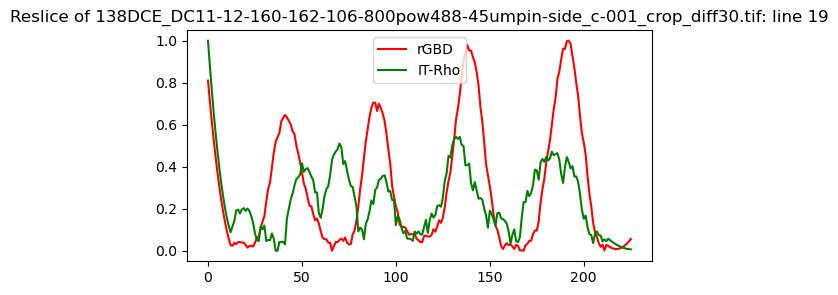

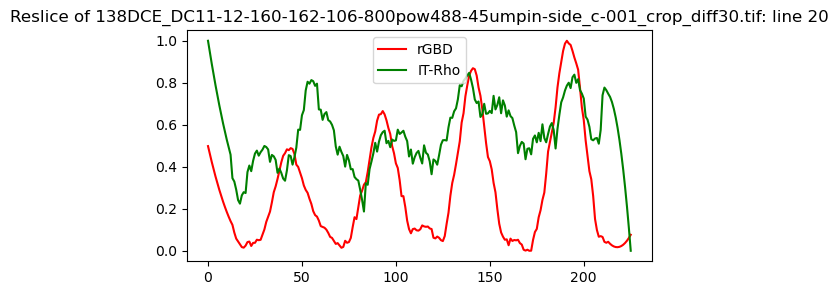

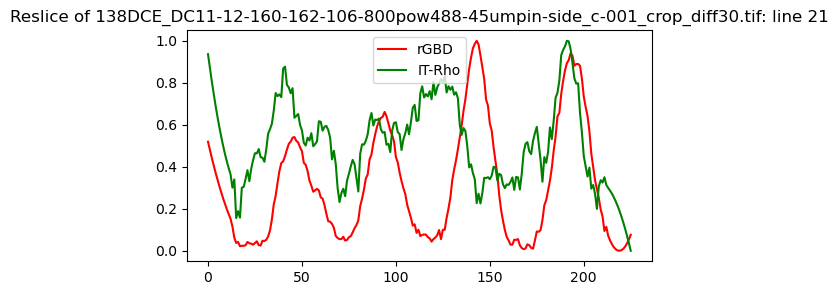

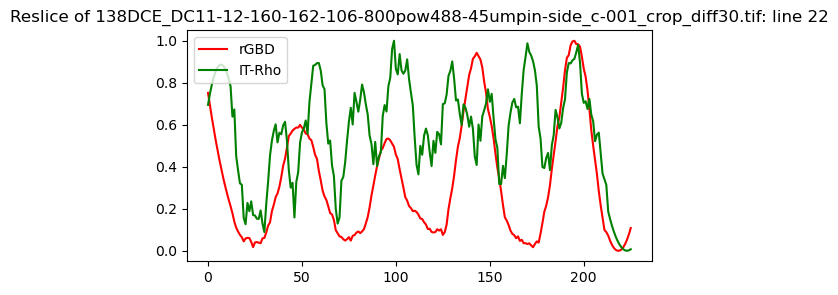

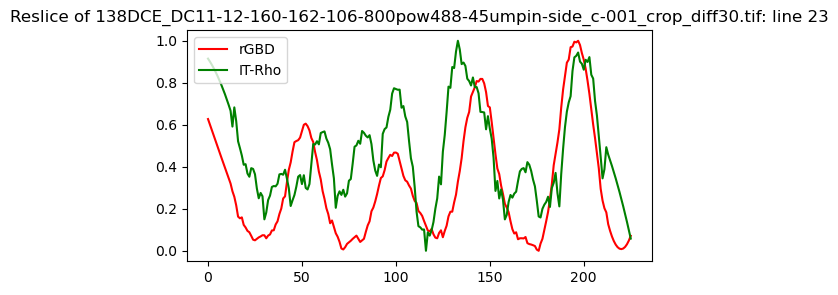

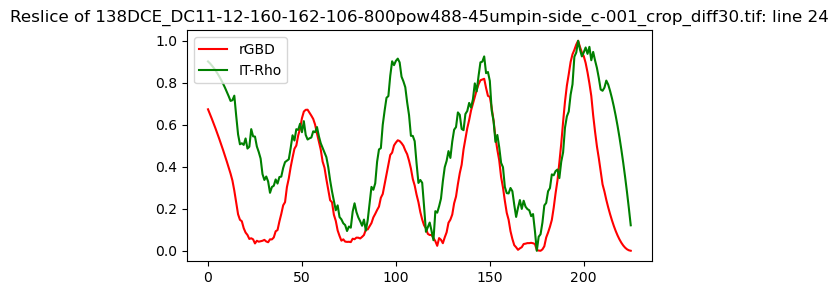

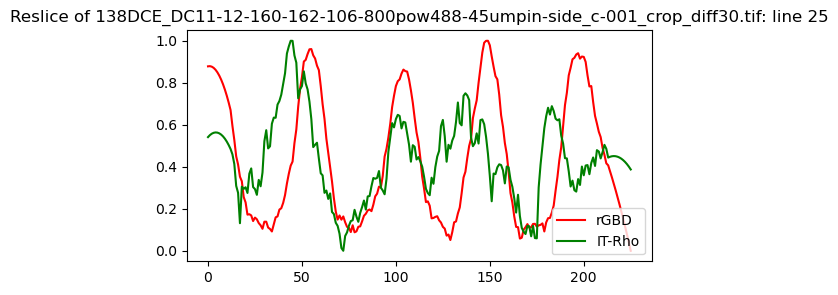

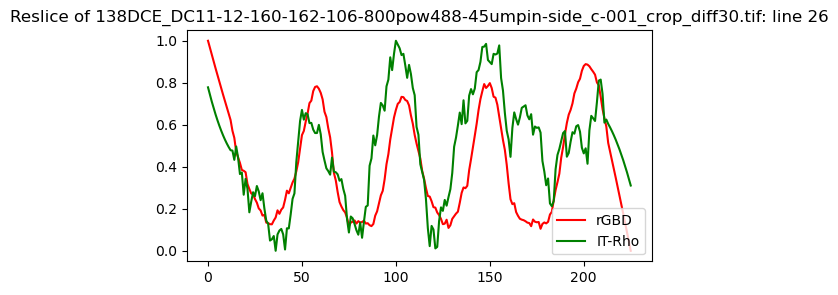

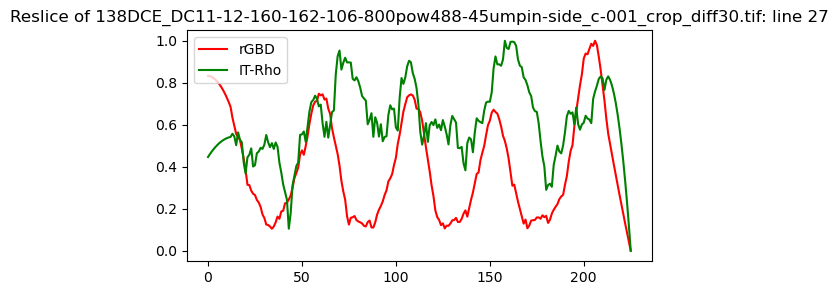

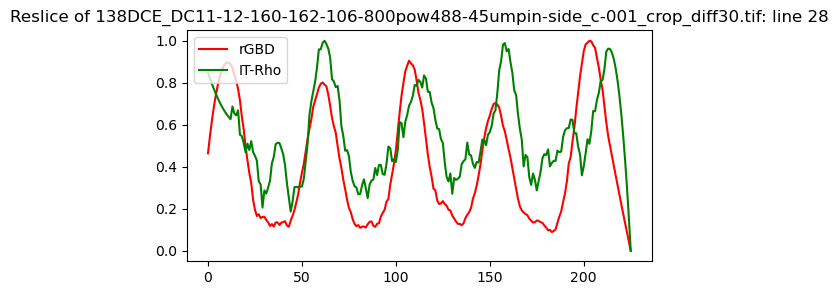

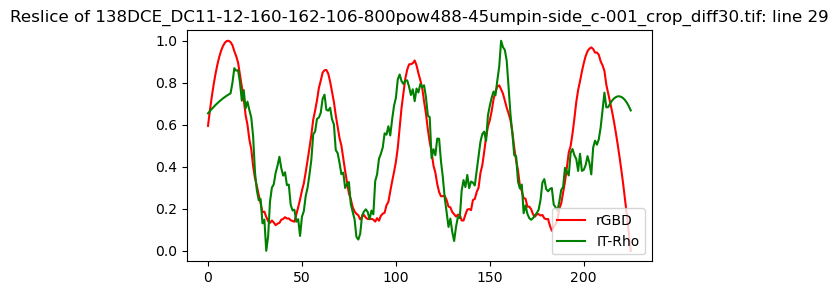

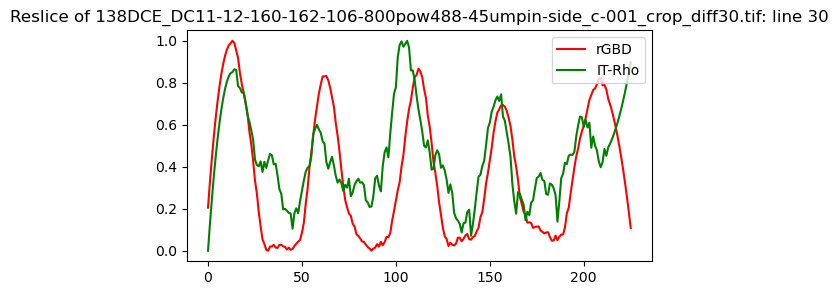

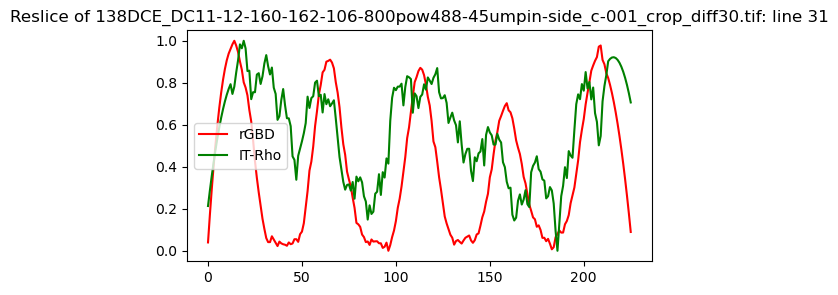

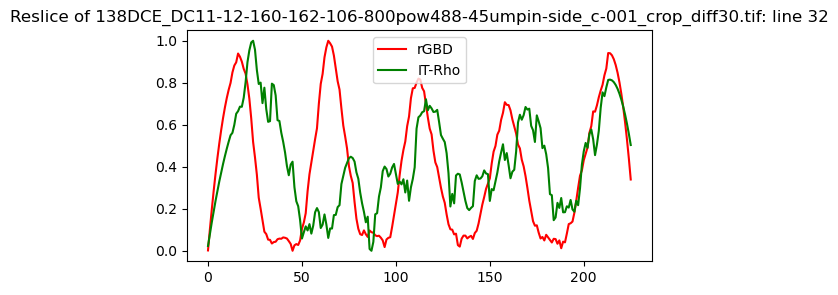

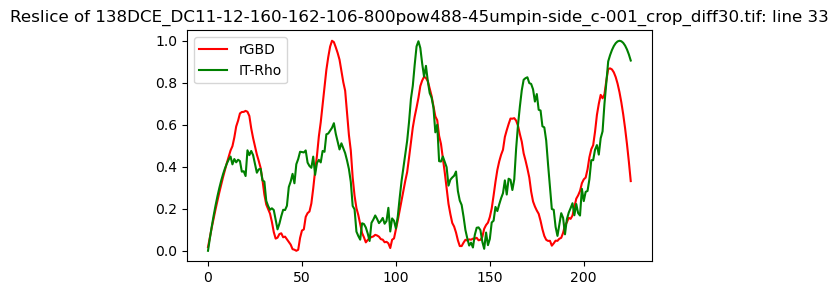

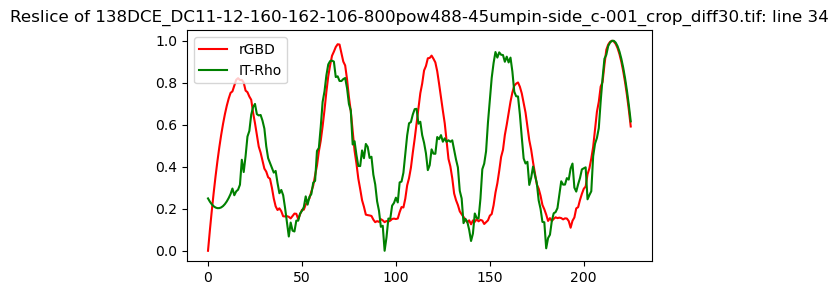

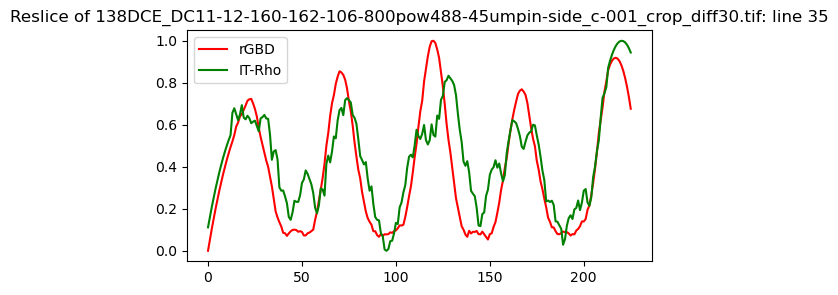

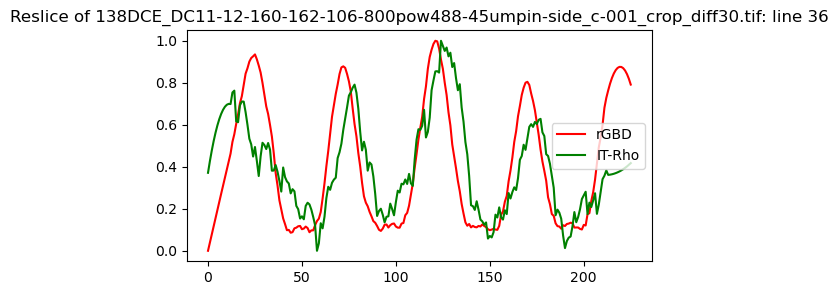

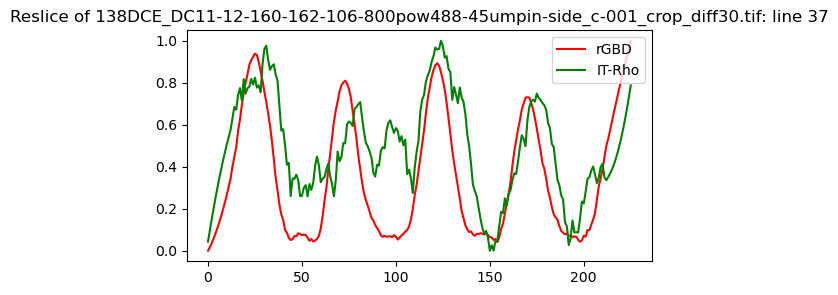

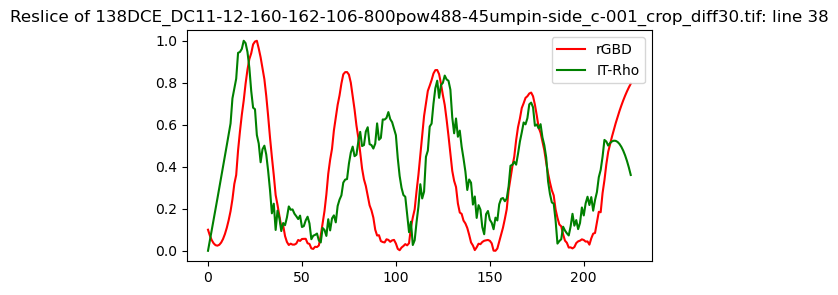

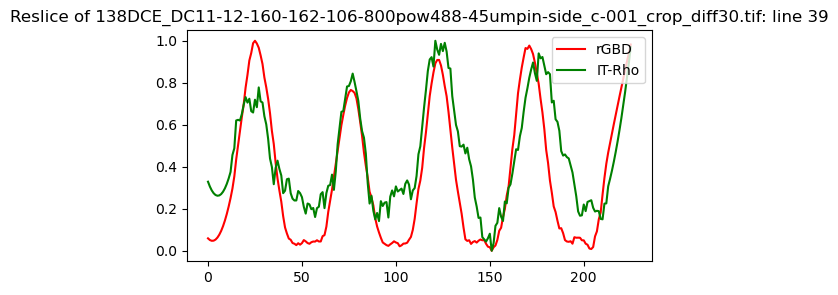

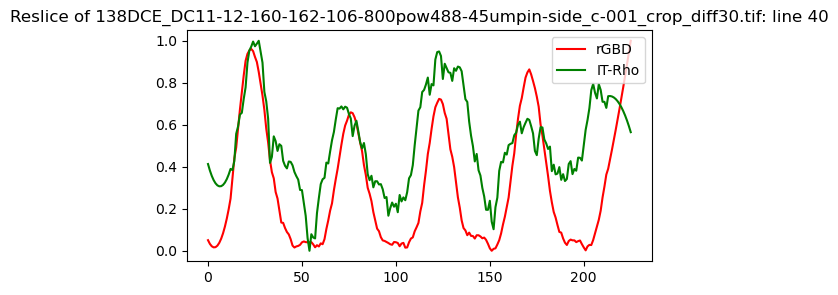

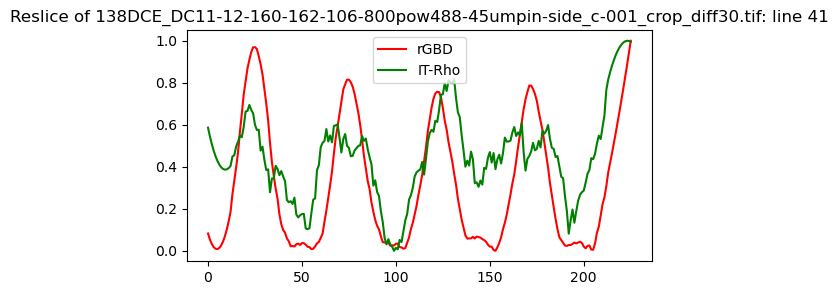

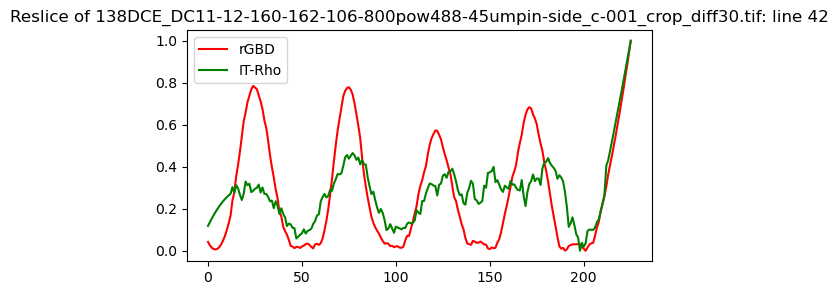

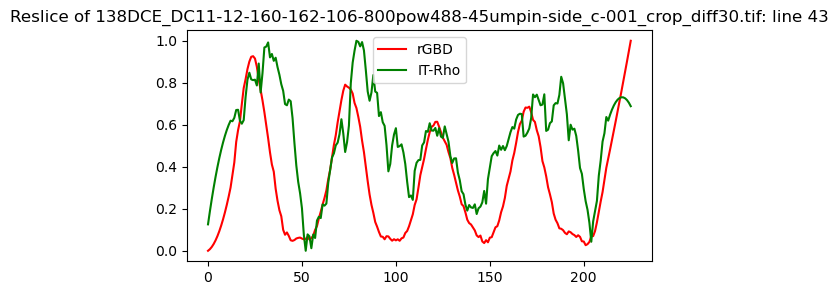

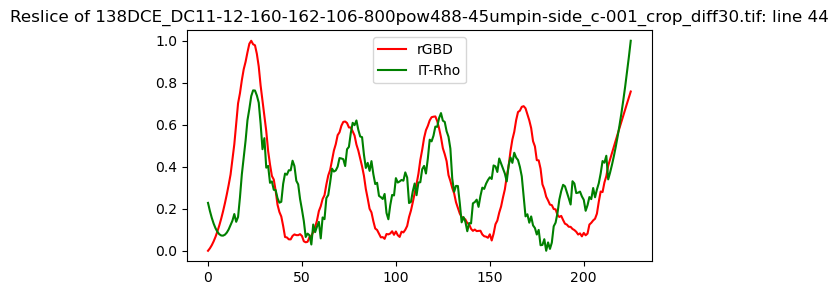

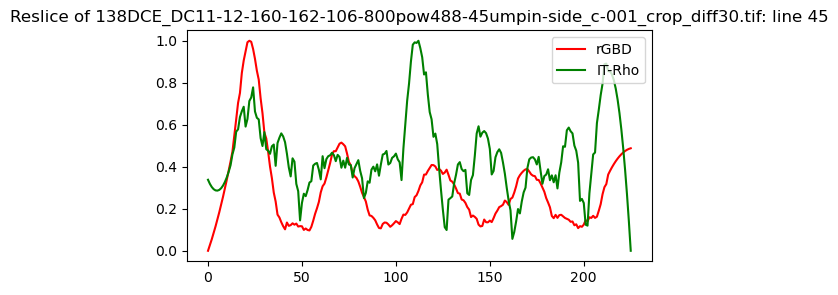

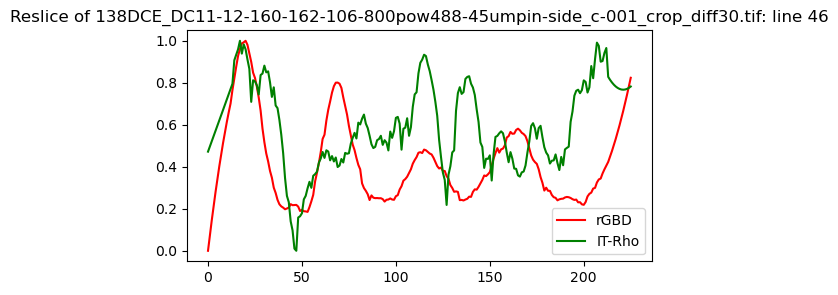

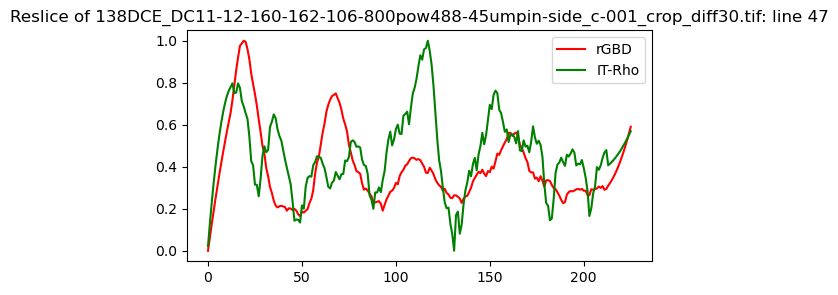

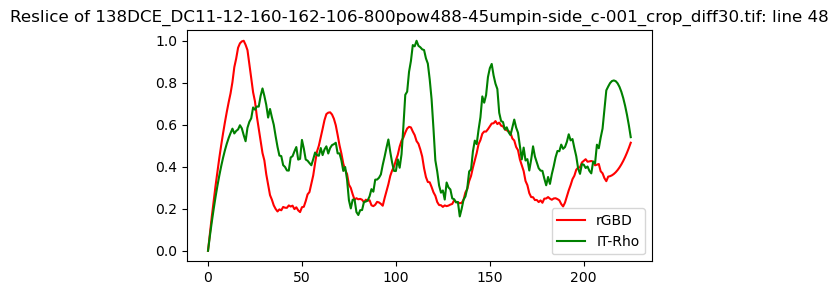

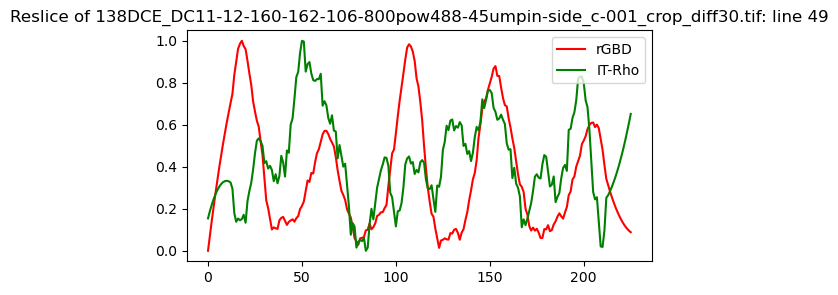

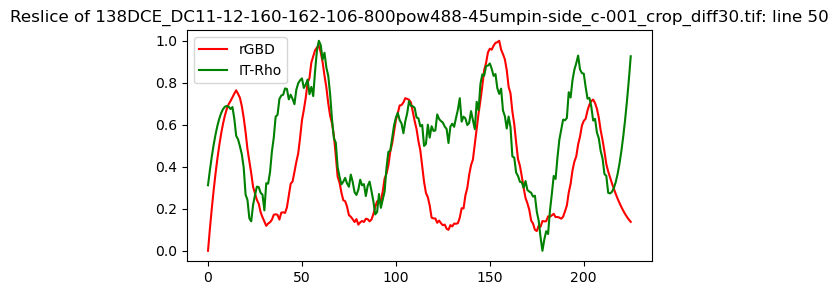

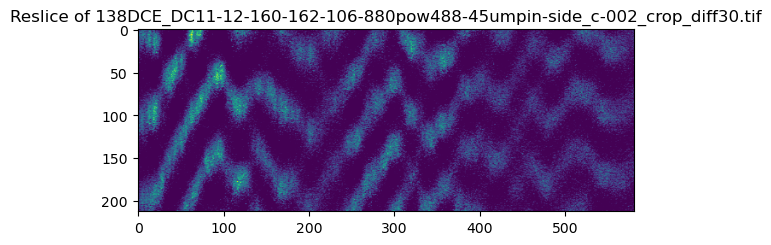

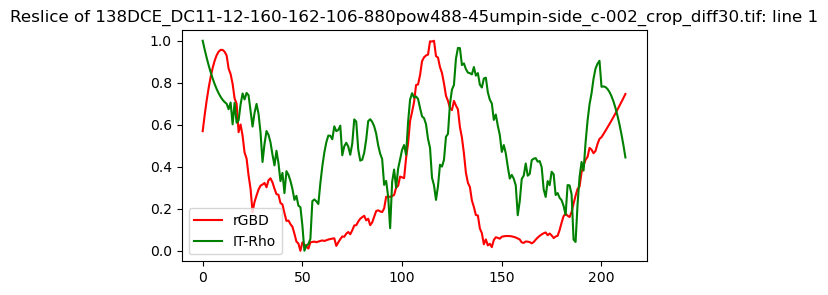

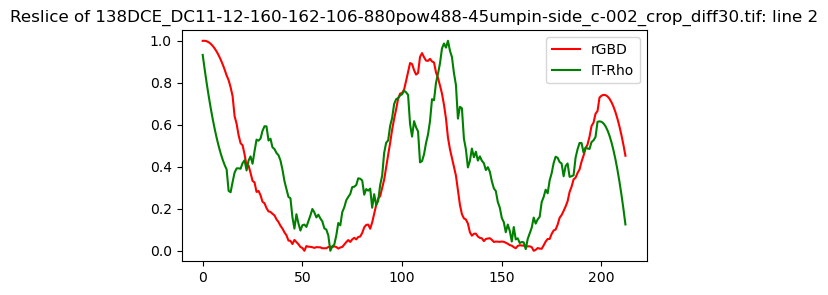

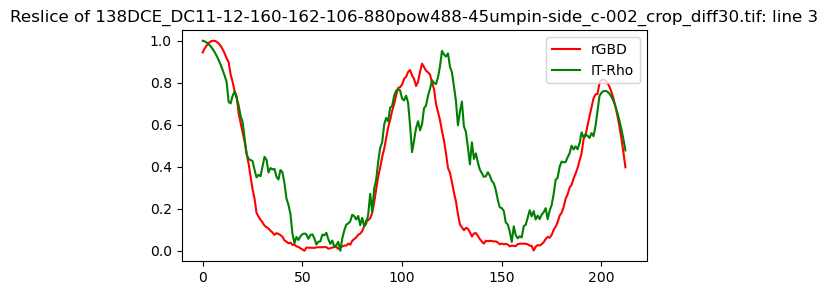

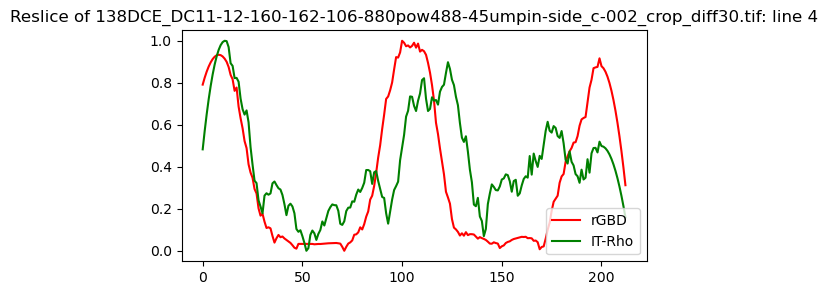

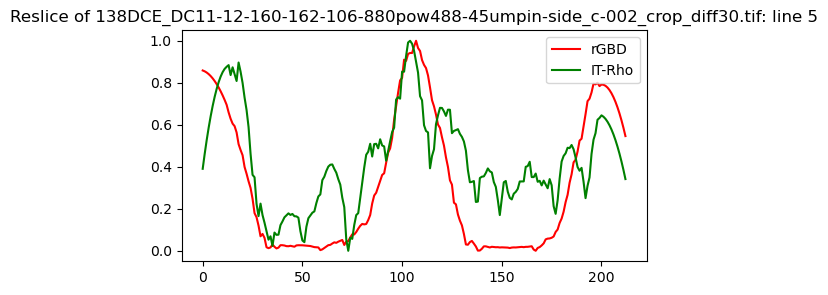

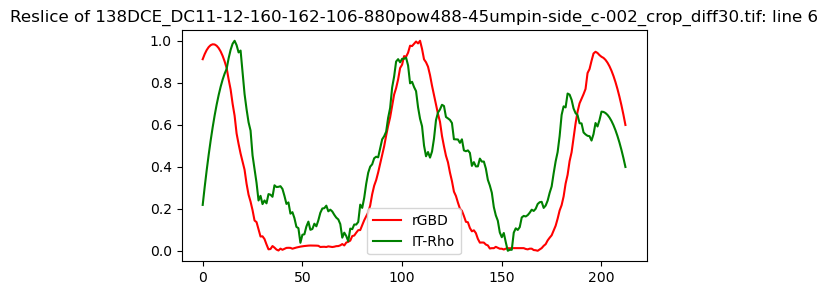

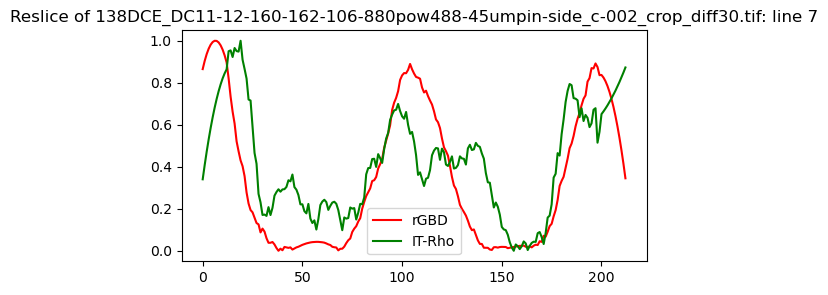

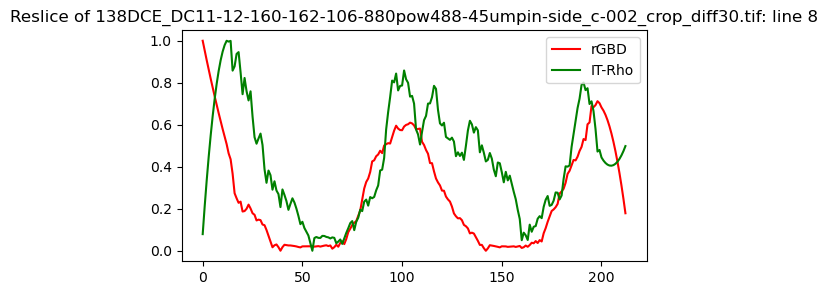

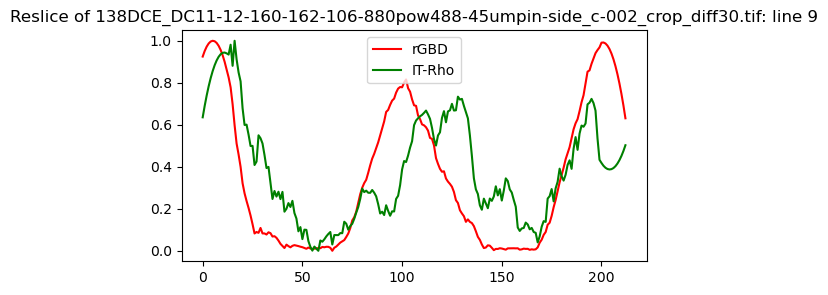

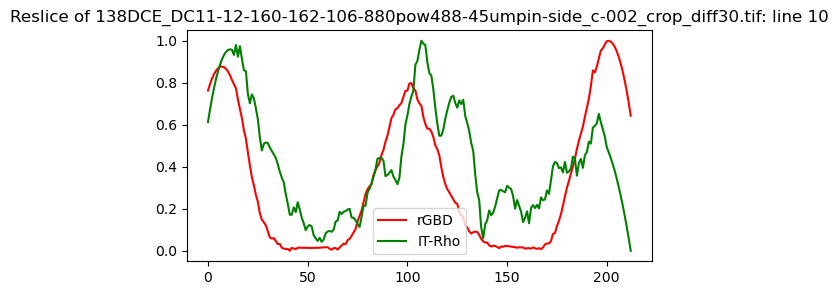

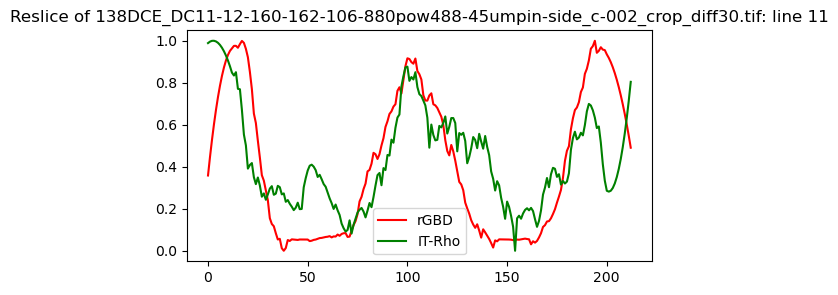

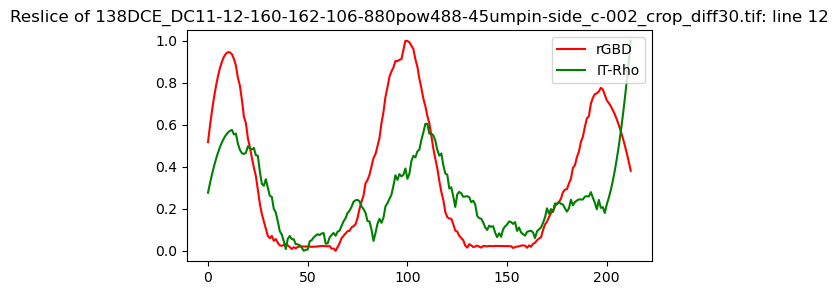

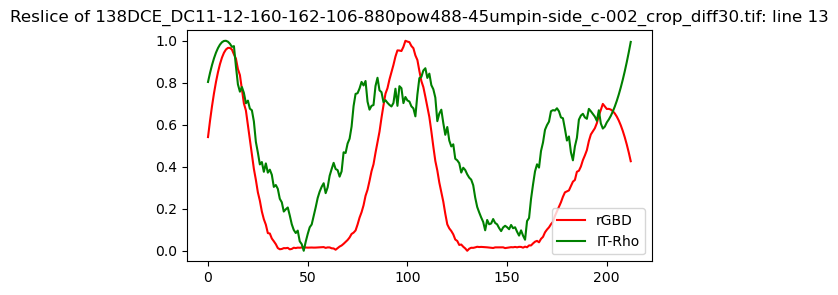

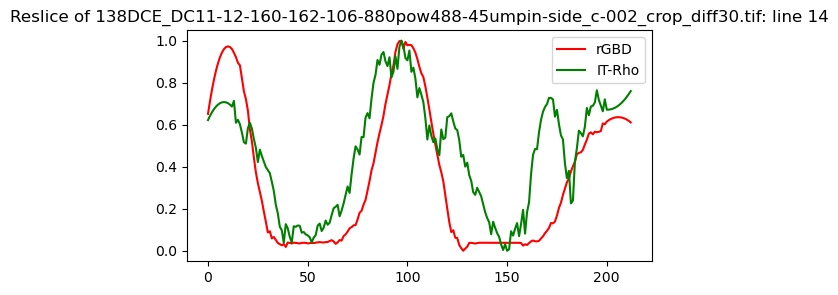

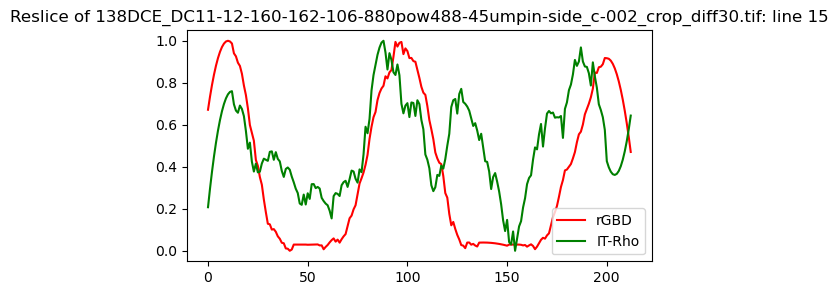

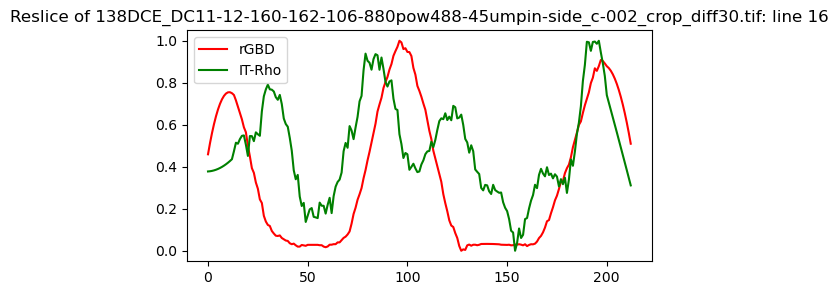

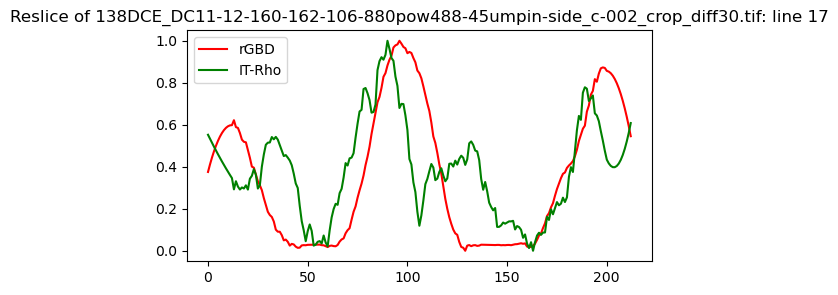

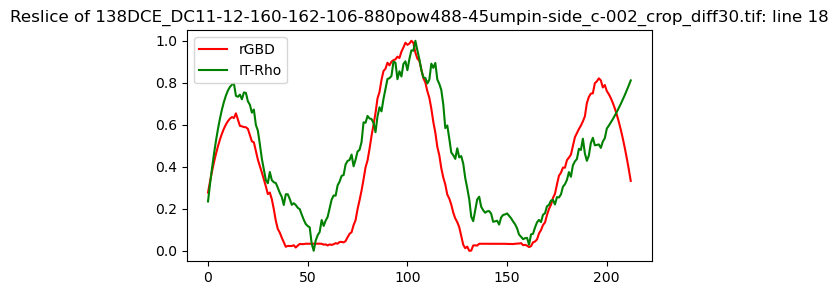

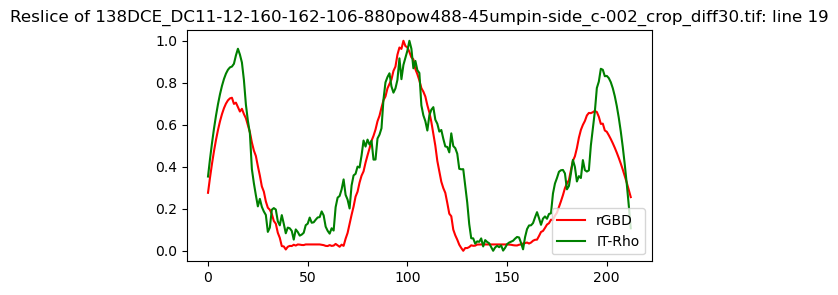

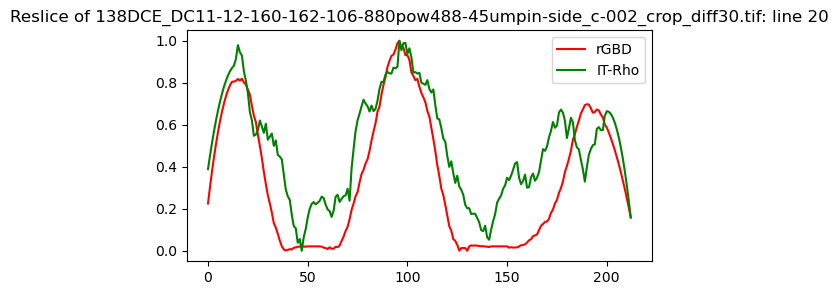

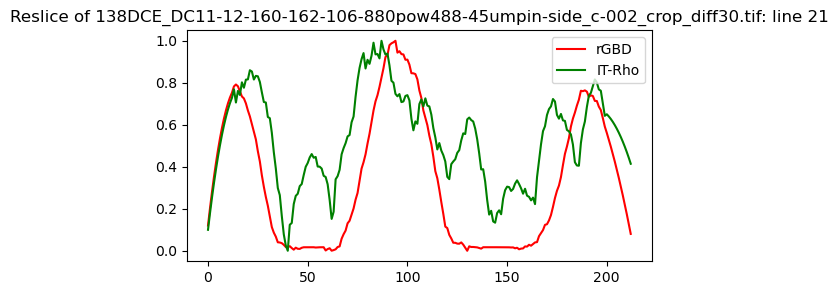

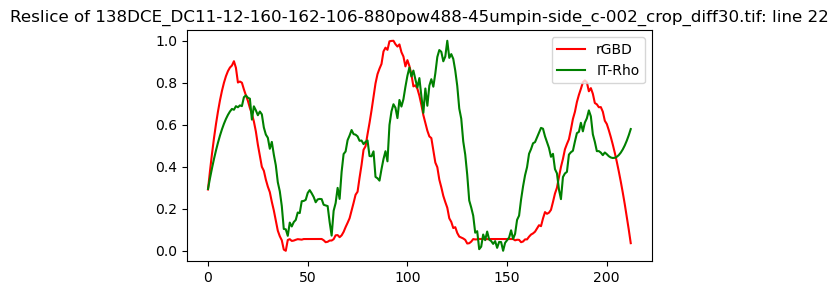

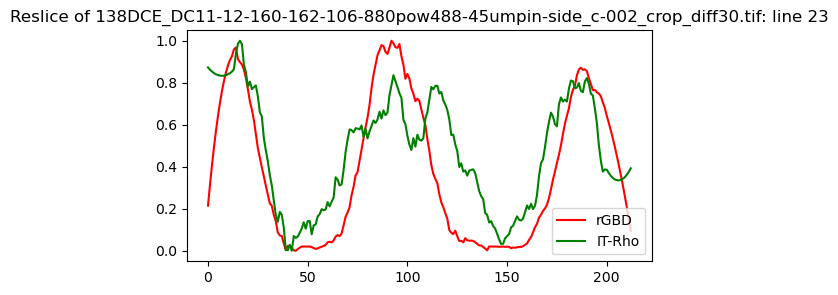

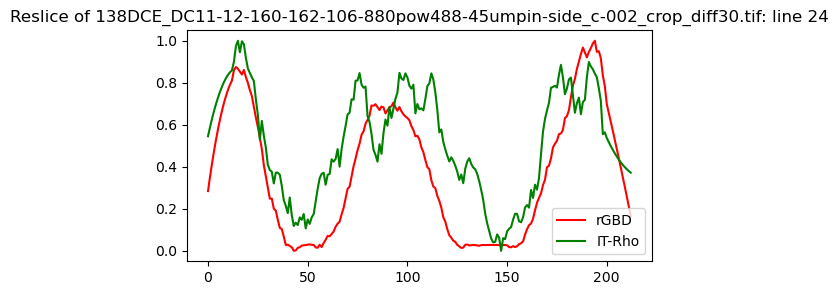

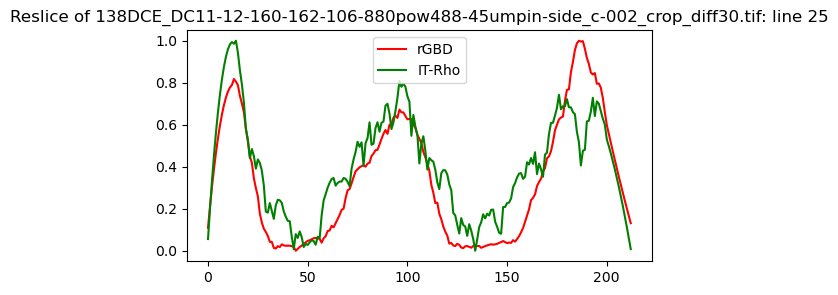

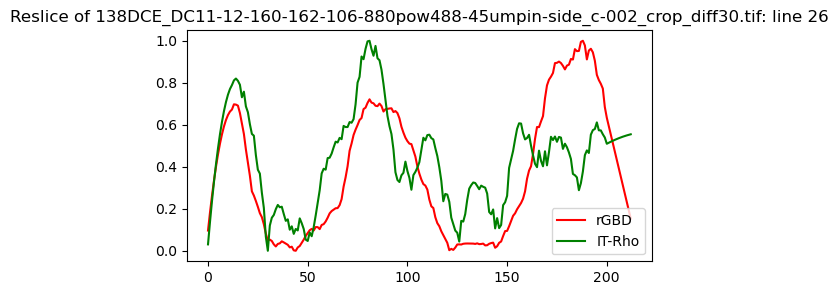

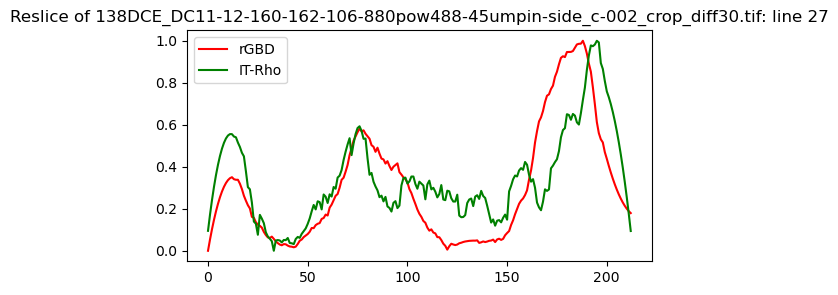

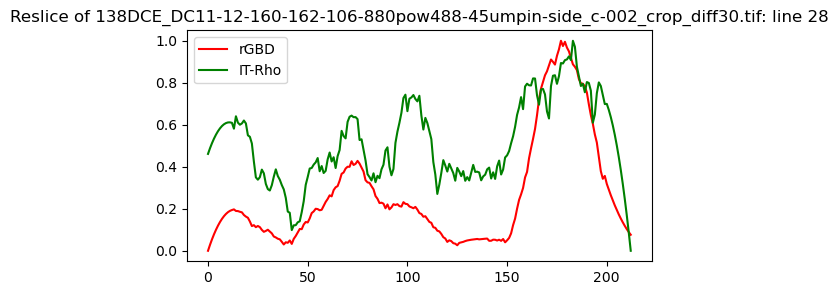

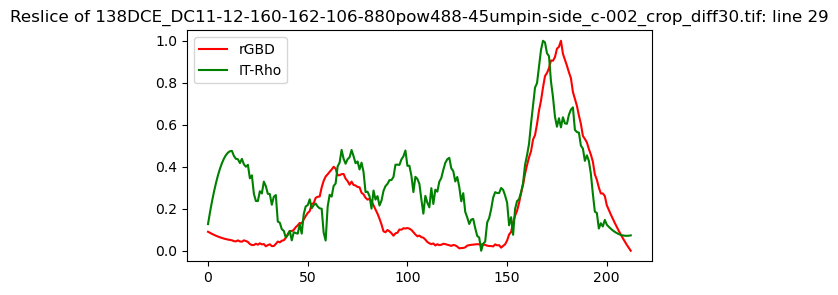

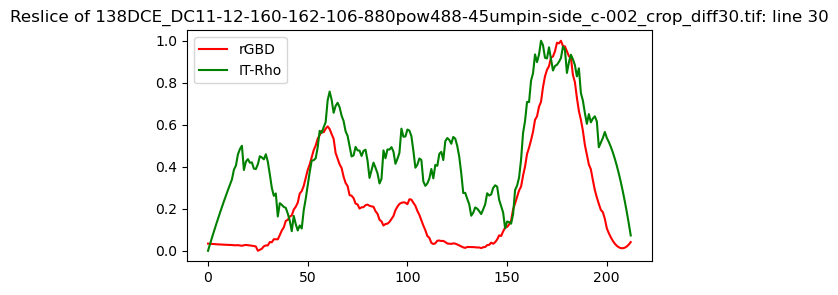

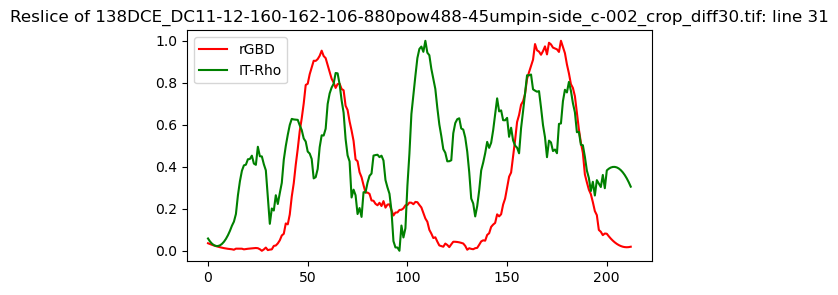

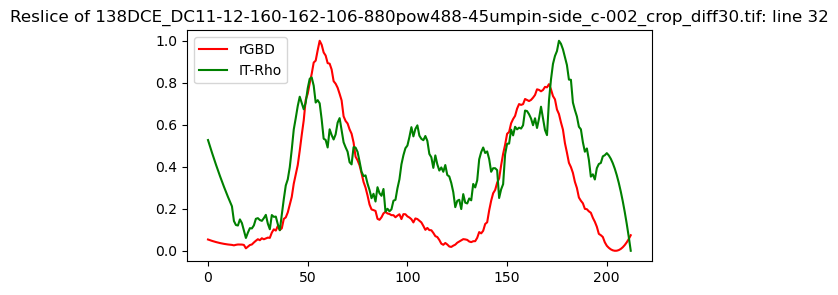

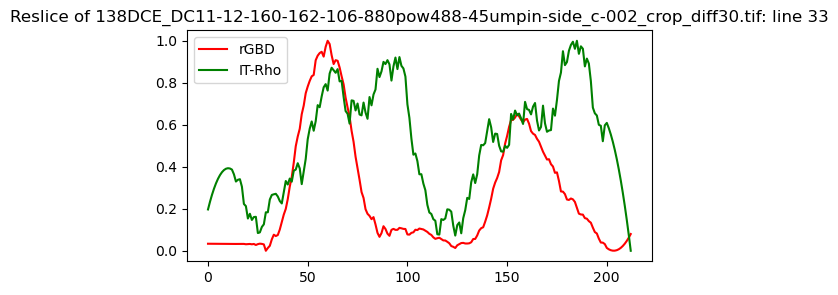

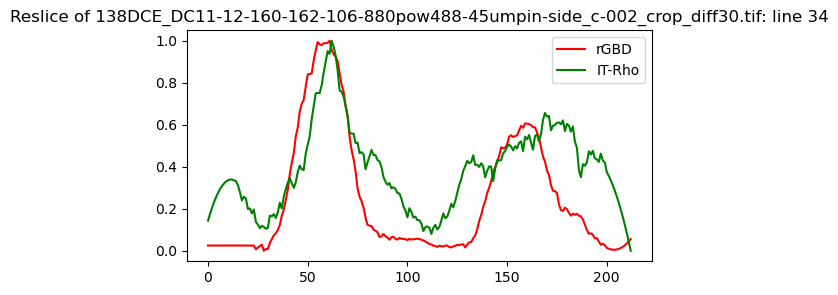

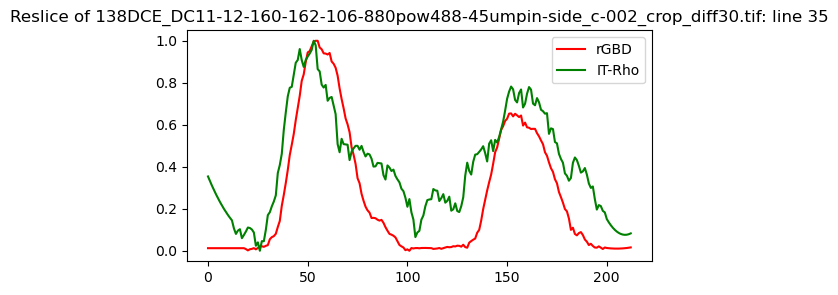

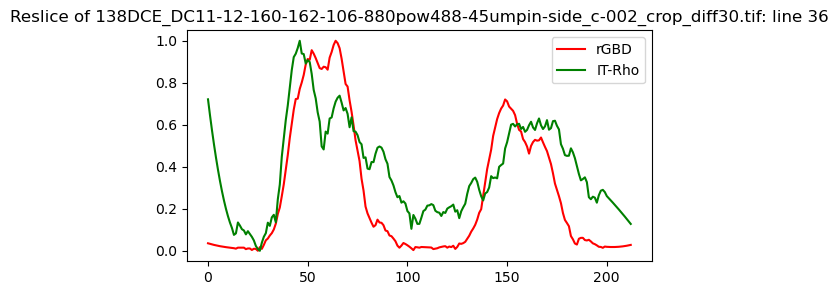

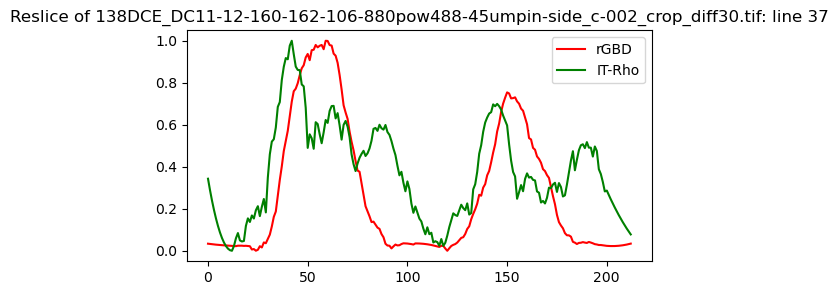

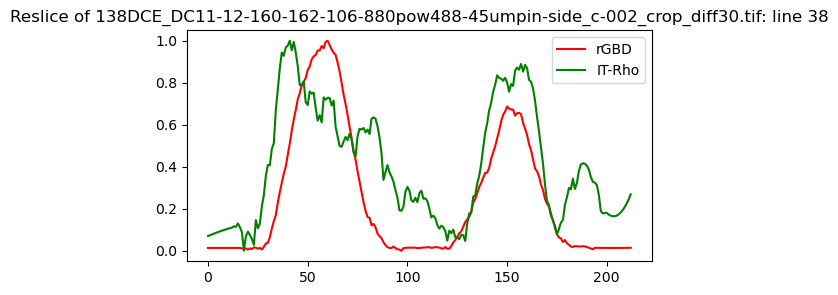

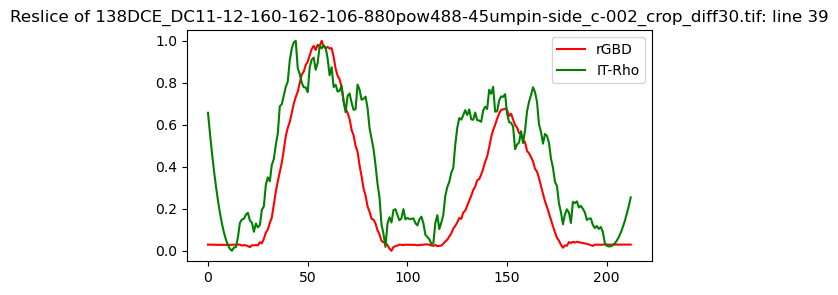

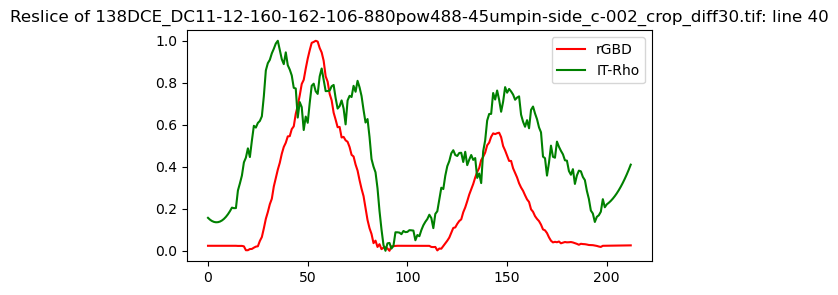

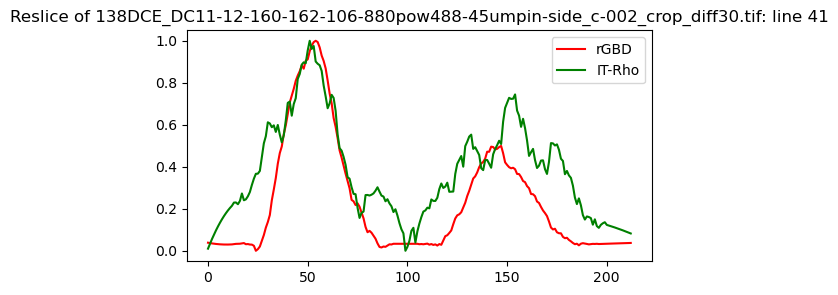

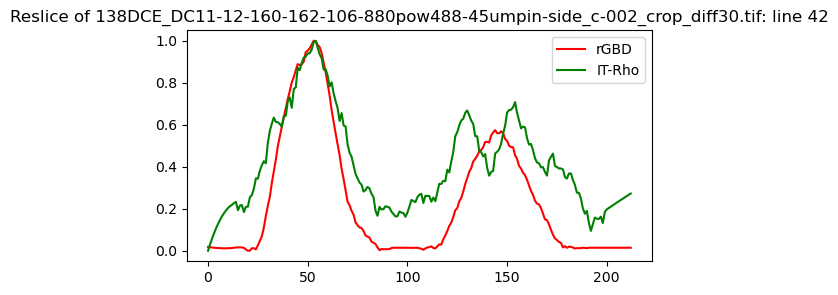

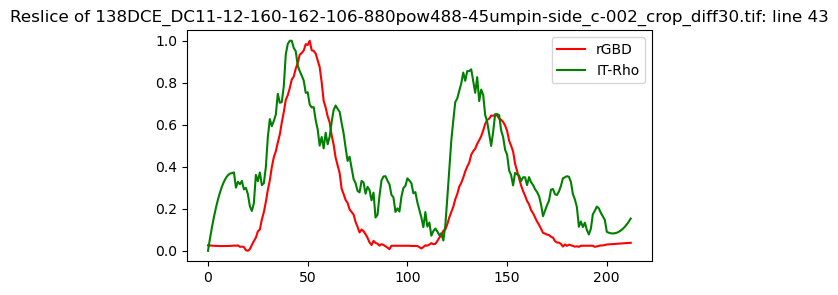

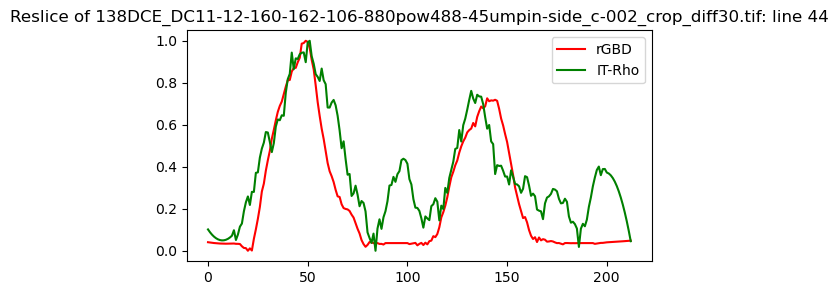

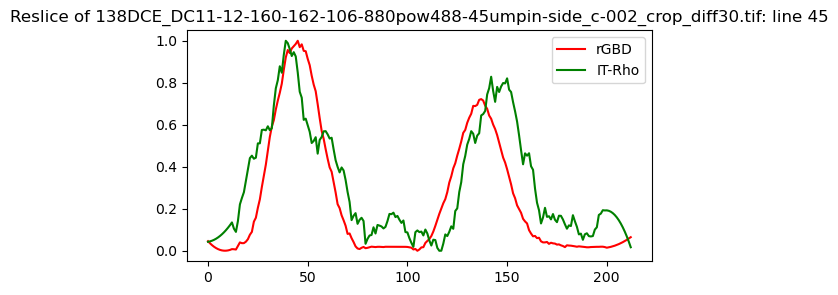

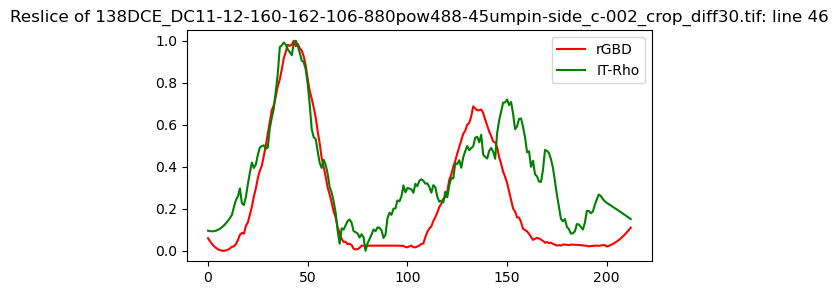

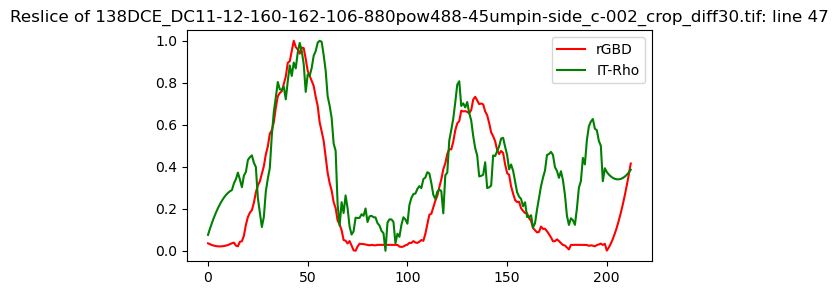

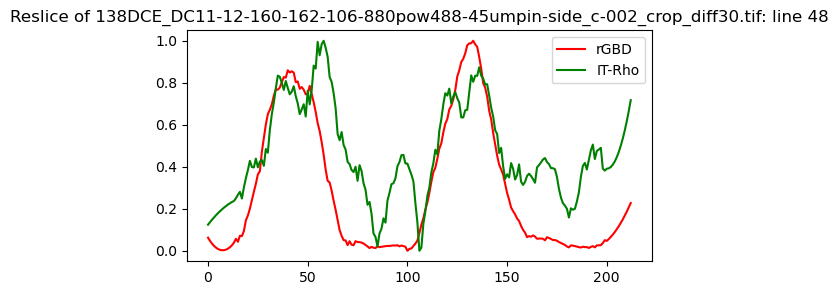

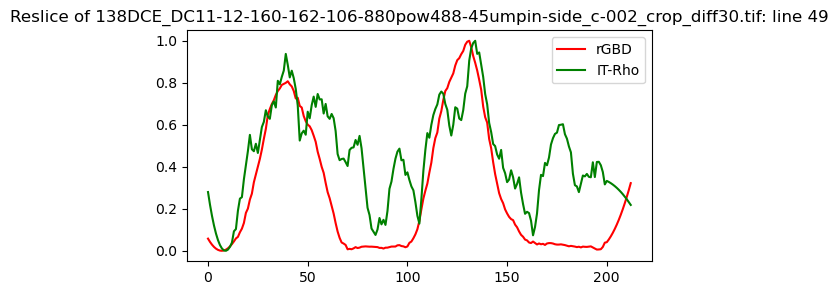

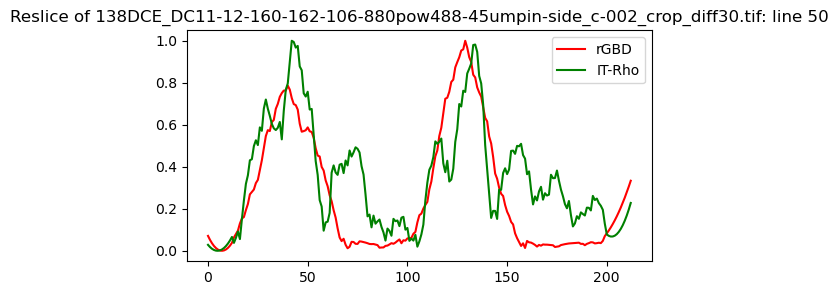

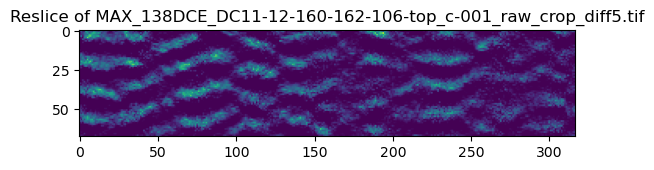

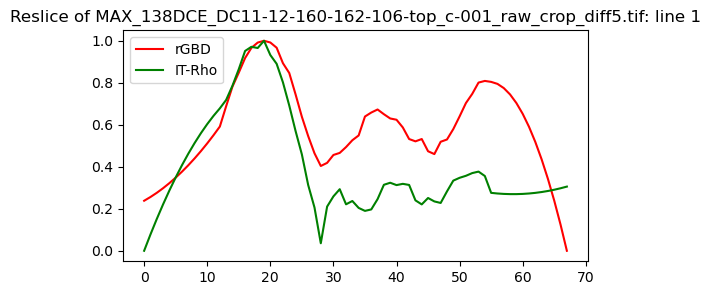

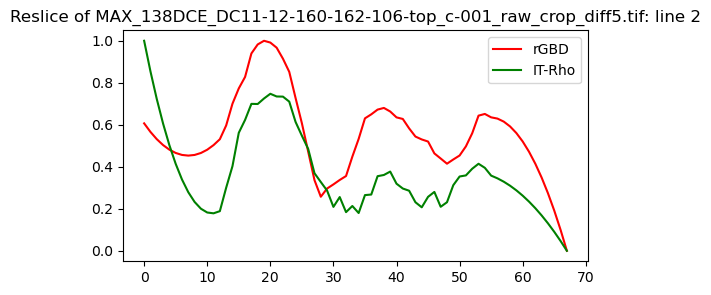

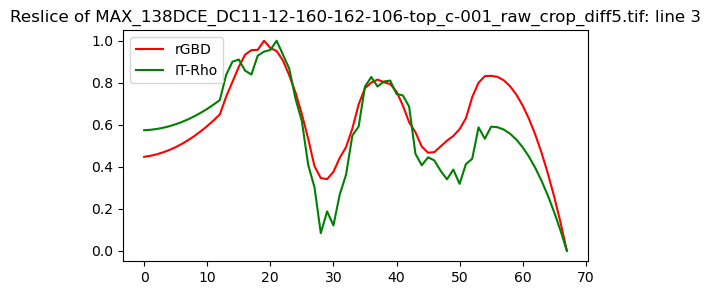

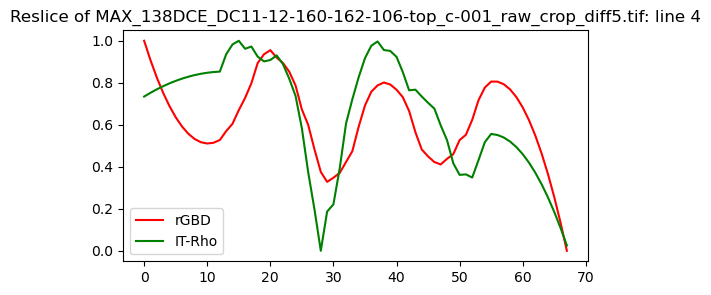

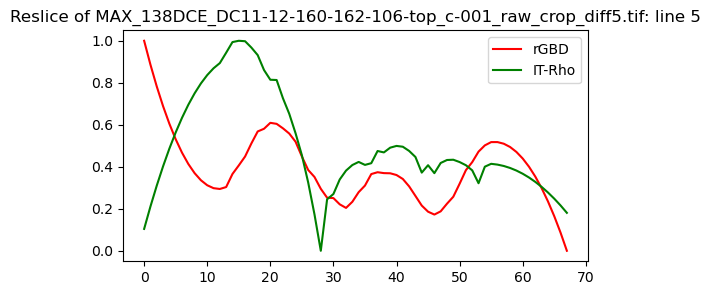

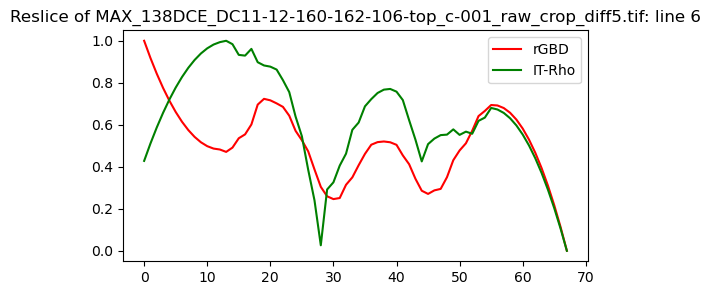

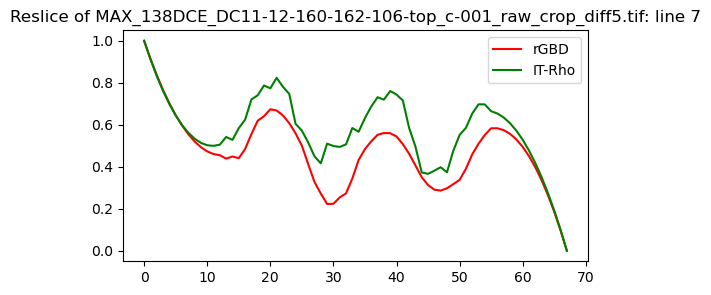

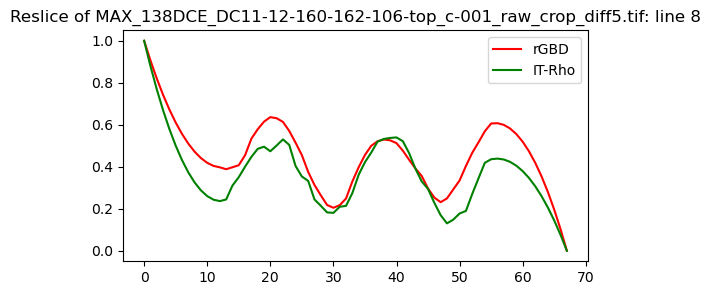

KeyboardInterrupt: 

<Figure size 600x300 with 0 Axes>

In [3]:
import pathlib
import tifffile as tiff
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

'''THis script takes a path containing images of kymographs. It will then create a vertical line scan for each 
column of pixels and plot them. Code currently assumes that there are two channels'''

input_path = '/Users/domchom/Desktop/kymogrpahs'

def convert_images(directory):
    input_path = pathlib.Path(directory)
    images = {}

    for file_path in input_path.glob('*.tif'):
        try:
            # Load the TIFF file into a numpy array
            image = tiff.imread(file_path)

            # standardize image dimensions
            with tiff.TiffFile(file_path) as tif_file:
                metadata = tif_file.imagej_metadata
            num_channels = metadata.get('channels', 1)
            image = image.reshape(num_channels, 
                                    image.shape[-2],  # rows
                                    image.shape[-1])  # cols
            

            images[file_path.name] = image
                        
        except tiff.TiffFileError:
            print(f"Warning: Skipping '{file_path.name}', not a valid TIF file.")

    # Sort the dictionary keys alphabetically
    images = {key: images[key] for key in sorted(images)}

    return images 

def create_linescans(image):
    channel1_data = []
    channel2_data = []
    for i in range(image.shape[-1]):
        channel1_col = image[0, :, i]
        channel2_col = image[1, :, i]
        channel1_col = sig.savgol_filter(channel1_col, window_length = 25, polyorder = 2)
        channel2_col = sig.savgol_filter(channel2_col, window_length = 25, polyorder = 2)

        channel1_col = (channel1_col - np.min(channel1_col)) / (np.max(channel1_col) - np.min(channel1_col))
        channel2_col = (channel2_col - np.min(channel2_col)) / (np.max(channel2_col) - np.min(channel2_col))
                                                                
        # Append the pixel values to the corresponding data list
        channel1_data.append(channel1_col)
        channel2_data.append(channel2_col)

    return channel1_data, channel2_data


if __name__ == "__main__":
    image_stack = convert_images(input_path)
    titles = []
    for image in image_stack.keys():
        titles.append(image)
    n = 0
    for image in image_stack.values():
        plt.imshow(image[0])
        plt.title(f'{titles[n]}')
        plt.show()
        for i in range(image.shape[-1])[:50]:
            plt.subplots(figsize=(6, 3))
            channel1_data, channel2_data = create_linescans(image)
            plt.plot(channel1_data[i], label='rGBD', color="red")
            plt.plot(channel2_data[i], label='IT-Rho',  color="green")
            plt.title(f'{titles[n]}: line {i + 1}')
            plt.legend()
            plt.show()
        n += 1